In [89]:
import pickle
from gensim.models import word2vec
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# from chembl_webresource_client.new_client import new_client
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, GRU, SpatialDropout1D, LSTM, Dropout
from keras.layers import BatchNormalization, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [3]:
with open("mol_sentences.pkl", "rb") as file:
    sentences = pickle.load(file)

In [4]:
model = word2vec.Word2Vec.load('./model_300dim.pkl')

In [5]:
vectors = []

for sentence in sentences:
    vector = []
    for word in sentence[3]:
        try:
            vector+=list(model.wv.word_vec(word))
        except:
            vector+=([0 for a in range(0, 300)])
    vectors.append(vector)
    
vectors = np.asarray(vectors)

In [6]:
sum_vectors = []

for vector in vectors:
    arr = np.asarray(vector)
    arr = arr.reshape((int(arr.shape[0]/300), 300) )
    sum_vectors.append(arr.sum(axis=0))

sum_vectors = np.asarray(sum_vectors)

In [7]:
atc = [a[1][0] for a in sentences]
le = LabelEncoder()
le.fit(atc)

atc = le.transform(atc)

In [60]:
X = sum_vectors
y = atc

atc_counter = Counter(y)
top_atc = [9,2,6]#[a for a, _ in atc_counter.most_common(4)]

temp_x = []
temp_y = []

for i in range(y.shape[0]):
    if y[i] in top_atc:
        temp_x.append(X[i])
        temp_y.append(y[i])
        
X = np.asarray(temp_x)
y = np.asarray(temp_y)

atc_labels = le.inverse_transform(np.unique(y))

/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=int(random.random()*100))

In [86]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [87]:
def accuracy(y_true, y_pred, atc_labels=atc_labels):
    print("Overall Accuracy:", np.sum(np.equal(y_true, y_pred))/y_true.shape[0])
    matrix = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, annot=True,cbar=False, xticklabels=atc_labels, yticklabels=atc_labels)

Overall Accuracy: 0.8006042296072508
             precision    recall  f1-score   support

          2       0.67      0.76      0.71        86
          6       0.79      0.92      0.85        84
          9       0.90      0.76      0.83       161

avg / total       0.81      0.80      0.80       331



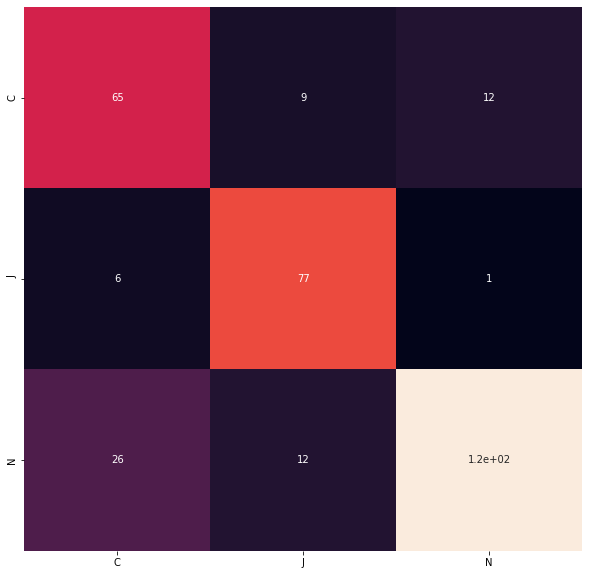

In [88]:
y_pred = neigh.predict(X_test)
accuracy(y_pred, y_test, atc_labels)

In [27]:
X = sum_vectors
y = atc

atc_counter = Counter(y)
top_atc = [a for a, _ in atc_counter.most_common(3)]

temp_x = []
temp_y = []

for i in range(y.shape[0]):
    if y[i] in top_atc:
        temp_x.append(X[i])
        temp_y.append(y[i])
        
X = np.asarray(temp_x)
y = np.asarray(temp_y)

atc_labels = le.inverse_transform(np.unique(y))

oeAtc = OneHotEncoder(sparse=False)
oeAtc.fit(y.reshape(-1, 1))
y = oeAtc.transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=int(random.random()*100))

/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [28]:
class Network:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.model.add(Dense(50, input_dim=300, activation='relu'))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, X, y, X_test, y_test, epochs=20):
        self.model.fit(X, y, epochs=epochs, validation_data=(X_test, y_test))
    
    def test(self, X, y):
        y_pred = self.model.predict(X).argmax(axis=1)
        y_true = y.argmax(axis=1)
        accuracy(y_true, y_pred)
        

In [29]:
network = Network(len(atc_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 153       
Total params: 20,303
Trainable params: 20,303
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
network.train(X_train, y_train, X_test, y_test, epochs=10)

Instructions for updating:
Use tf.cast instead.
Train on 789 samples, validate on 339 samples
Epoch 1/10
789/789 [==============================] - 2s 2ms/step - loss: 1.2462 - acc: 0.4487 - val_loss: 0.9972 - val_acc: 0.5605
Epoch 2/10
789/789 [==============================] - 0s 74us/step - loss: 0.9862 - acc: 0.5133 - val_loss: 0.9229 - val_acc: 0.5959
Epoch 3/10
789/789 [==============================] - 0s 61us/step - loss: 0.9011 - acc: 0.5805 - val_loss: 0.8896 - val_acc: 0.6313
Epoch 4/10
789/789 [==============================] - 0s 85us/step - loss: 0.8234 - acc: 0.6324 - val_loss: 0.8674 - val_acc: 0.6224
Epoch 5/10
789/789 [==============================] - 0s 80us/step - loss: 0.8117 - acc: 0.6464 - val_loss: 0.8903 - val_acc: 0.6018
Epoch 6/10
789/789 [==============================] - 0s 65us/step - loss: 0.7850 - acc: 0.6578 - val_loss: 0.8775 - val_acc: 0.6224
Epoch 7/10
789/789 [==============================] - 0s 81us/step - loss: 0.7534 - acc: 0.6755 - val_loss: 0

Overall Accuracy: 0.6312684365781711
             precision    recall  f1-score   support

          0       0.76      0.35      0.48       100
          1       0.51      0.78      0.62        92
          2       0.70      0.73      0.72       147

avg / total       0.67      0.63      0.62       339



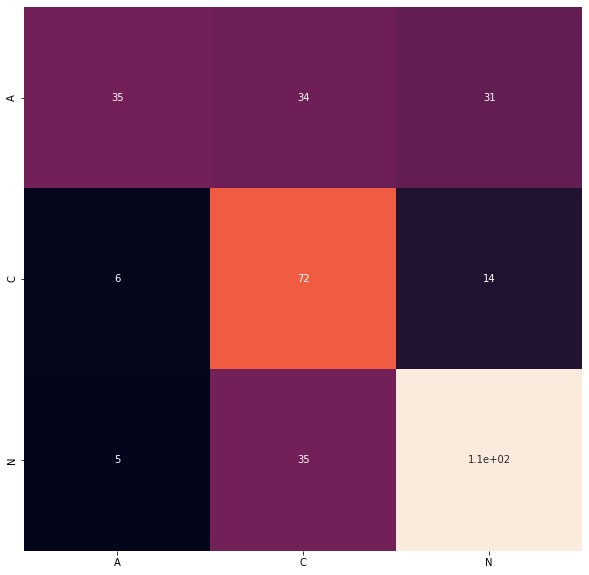

In [31]:
s = network.test(X_test, y_test)

In [199]:
X

array([[ -4.75496054, -10.4296627 ,  -7.99642181, ..., -34.99038696,
        -43.00680923,  -6.82294369],
       [  2.17881417,  -7.84141874,  -2.18737435, ..., -23.33225822,
        -46.16866684,  -2.20392513],
       [ -6.64861727, -13.28558826,  -8.4565897 , ..., -36.02462387,
        -46.71065903,  -6.32206917],
       ..., 
       [ -1.34862363,  -6.26717758,  -7.62388563, ..., -31.92769432,
        -51.0817337 ,  -5.77554989],
       [  0.60033071,  -2.32285595,  -2.30074096, ...,  -1.22332311,
         -7.74127626,  -0.56419826],
       [  1.34407198,  -6.84478283,  -1.78270006, ...,  -2.31541252,
        -10.56662655,   0.38672185]])

In [201]:
le.inverse_transform(y)

array(['L', 'H', 'H', ..., 'S', 'P', 'C'],
      dtype='<U1')

In [202]:
import pickle

In [205]:
with open("embeddings_y.pkl", "wb") as file:
    pickle.dump(y, file)

In [44]:
Counter(atc).most_common(4)

[(9, 469), (2, 344), (0, 315), (6, 288)]